This notebook contains a brief demo to illustrate the data evaluation in <em>Walheim, J., Dillinger, H., Gotschy, A. et al. 5D Flow Tensor MRI to Efficiently Map Reynolds Stresses of Aortic Blood Flow In-Vivo. Sci Rep 9, 18794 (2019). https://doi.org/10.1038/s41598-019-55353-x</em>.

The data used here are limited to a systolic frame to reduce the size of the demo code. Processing was performed as follows.
Reynolds stresses were encoded using a six directional multipoint velocity encoding. For each of the velocity encodings, 5D flow acquisition and reconstruction was performed as in <em>Walheim, J., Dillinger, H. & Kozerke, S. Multipoint 5D flow cardiovascular magnetic resonance - accelerated cardiac- and respiratory-motion resolved mapping of mean and turbulent velocities. J Cardiovasc Magn Reson 21, 42 (2019). https://doi.org/10.1186/s12968-019-0549-0' </em> (reconstruction code to be found in https://osf.io/36gdr/). The reconstruction first reconstructs each velocity encoding separately, enforcing a low-rank model in small image patches (locally low rank) and then combines different encoding strengths for each direction using a Bayesian approach. The final output are estimates of mean velocities and intra-voxel standard deviations of turbulent velocities for each of the encoded directions (results_v and results_std in the following code).


In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd
import matplotlib
import scipy.io as sio
import h5py

from utils.functionsRST import *

%matplotlib notebook

resDir = './eval_invivo'

if (os.path.exists(resDir) == False):
    os.mkdir(resDir)
    
# display settings
vRange_X = np.array([0, 500])
cmap_X = matplotlib.cm.gray

vRange_tau = np.array([0, 800])
cmap_tau = matplotlib.cm.hot

vRange_TKE = np.array([0, 1000])
cmap_TKE = matplotlib.cm.hot

vRange_vel = np.array([0, 2])
cmap_vel = matplotlib.cm.jet

vRange_RST = np.array([0, 0.5])
cmap_RST = matplotlib.cm.hot
    

#load mean velocities and intravoxel standard deviations as estimated in 5D flow reconstruction
f = h5py.File('./example_results.h5','r')

indHP = 0 #heart phase to look at, here at 0, as data only comprises one systolic frame
results_std = np.array(f["results_std"])
results_std = results_std[:,:,:,indHP,None,:]
results_v = np.array(f["results_v"])

I = np.array(f["Ireal"])+1j*np.array(f["Iimag"])
I = I[:,:,:,indHP,None,:]

mask = np.array(f["mask"])

f.close()

(213, 135, 51, 1, 6)


In [21]:
rho = 1060 #density of blood

enc_NB_unif = np.array([[1., 0., 0.], #velocity encoding
         [0.,1.,0.],
         [0.,0.,1.],
         [0.707,0.707,0.],
         [0.707,0.,0.707],
         [0.,0.707,0.707]])

#determine Reynolds stresses from intravoxrel standard deviations (EQ 6 in Publication)
RST_vol = calcRST_ivsd(results_std,enc_NB_unif, rho) 
#Equation 12
TKE=0.5*np.sum(RST_vol[:,:,:,:,:3],4)*mask[:,:,:,:,0]

#Equation 13
ps = calcPrincipalStresses(RST_vol);
tau_max = mask[:,:,:,:,0]* (ps[:, :, :, :, 2] - ps[:, :, :, :, 0]) / 2;

#Equation 9
v_cart = getCartVelocities(results_v,enc_NB_unif)
v_mag = np.sqrt(np.sum(v_cart**2 ,4))*mask[:,:,:,:,0]

<IPython.core.display.Javascript object>


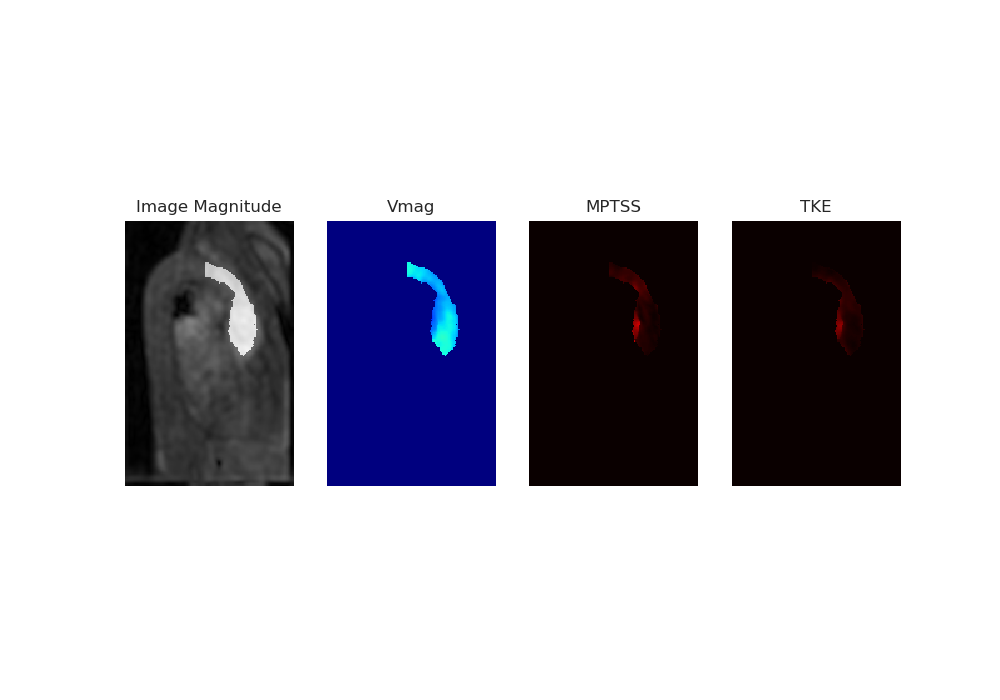

In [32]:
indSlc = 28
fig, ax = plt.subplots(1,4,figsize=(10, 7))  
imgplot = ax[0].imshow(np.abs(I[:,:,indSlc,0,0]).astype(float), interpolation='none', cmap=cmap_X, \
                     vmax=np.max(np.abs(I[:,:,indSlc,0,0]).flatten()), vmin=0)

imgplot = ax[0].imshow(mask[:,:,indSlc,0,0], cmap=cmap_X, alpha=0.5)



imgplot = ax[1].imshow(v_mag[:,:,indSlc,0].astype(float), interpolation='none',  cmap=cmap_vel,\
                     vmax=vRange_vel[1], vmin=vRange_vel[0])



imgplot = ax[2].imshow(tau_max[:,:,indSlc,0].astype(float), interpolation='none', cmap=cmap_tau, \
                     vmax=vRange_tau[1], vmin=vRange_tau[0])
imgplot = ax[3].imshow(TKE[:,:,indSlc,0].astype(float), interpolation='none', cmap=cmap_TKE, \
                     vmax=vRange_TKE[1], vmin=vRange_TKE[0])

ax[0].set_title('Image Magnitude')
ax[1].set_title('Vmag')
ax[2].set_title('MPTSS')
ax[3].set_title('TKE')


[ax[i].axis('off') for i in range(4) ]

plt.show()

    
    

In [24]:
df_TKE = pd.concat([pd.DataFrame({'volunteer':TKE[TKE!= 0].flatten()}), \
                     ], ignore_index=False,\
                   axis=1)          

df_TAU = pd.concat([pd.DataFrame({'volunteer':tau_max[tau_max!= 0].flatten()})
                   ],ignore_index=False, axis=1)          

df_vmag = pd.concat([pd.DataFrame({'volunteer':v_mag[v_mag!= 0].flatten()}), \
                    ],ignore_index=False, axis=1)                 

In [33]:
sns.set_style({"font.size":12})
sns.set_style("white")

colInd = df_vmag.columns



def createHistPlot(df,catlabel,datalabel,valrange,colInd,fname, unit):
    #fig, axes = plt.subplots(1,2,figsize=(10, 5))  

    fig, axes = plt.subplots(1,1,figsize=(4, 4))  

    for idx,ind in enumerate(colInd[:]):    
        g = sns.distplot( df[[ind]],  hist=False,ax=axes,kde_kws={"label":ind, "lw":2 })#,kde_kws={"lw": 1, "label":colInd[ind] })
        g.set(xlim=(valrange[0], valrange[1]))

    g.set_ylabel('Probability of value')
    g.set_xlabel(datalabel)
    
    plt.savefig(os.path.join(resDir,fname))
    plt.show()

def createBoxPlot(df,catlabel,datalabel,valrange,colInd,fname, unit):
    #fig, axes = plt.subplots(1,2,figsize=(10, 5))  
    fig, axes = plt.subplots(1,1,figsize=(4, 4))  

    g = sns.boxplot( data=df[colInd], linewidth=2.5, orient='v',ax=axes)
    g.set(ylim=(valrange[0], valrange[1]))
    g.set_ylabel(datalabel)
    g.set_xlabel(catlabel)
    
    means = df[colInd].mean().values
    stds = df[colInd].std().values
    if(means[0]<100):
        mean_labels = [str(np.round(s, 2))  for s in means]
        stds_labels = [str(np.round(s, 2))  for s in stds]
    else:
        mean_labels = [str(np.round(s, 1)) for s in means]
        stds_labels = [str(np.round(s, 1)) for s in stds]
    #ugly workaround, as I can't find way to move table, simply insert empty rows
    tmp = [str(' ') for s in range(np.size(means))]
    data = [tmp,tmp,tmp,tmp,mean_labels,stds_labels]
    table = plt.table(cellText=data,rowLabels=['','','','','mean ' + unit,'std ' + unit],loc='bottom',edges = 'open')

    plt.subplots_adjust(left=0.2, bottom=0.3,wspace=.5)
    
    plt.savefig(os.path.join(resDir,fname))
    plt.show()

          


<IPython.core.display.Javascript object>


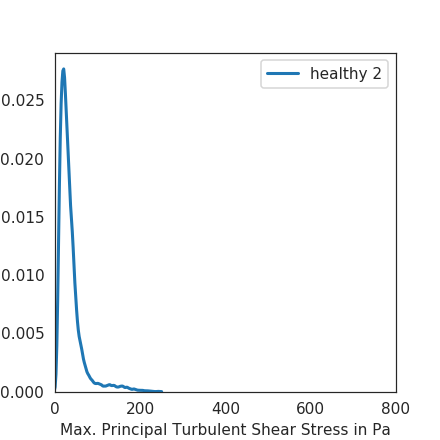

/home/jwalheim/.conda/envs/mri_stuff/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<IPython.core.display.Javascript object>


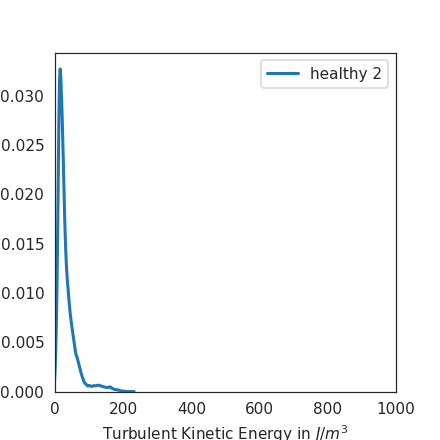

<IPython.core.display.Javascript object>


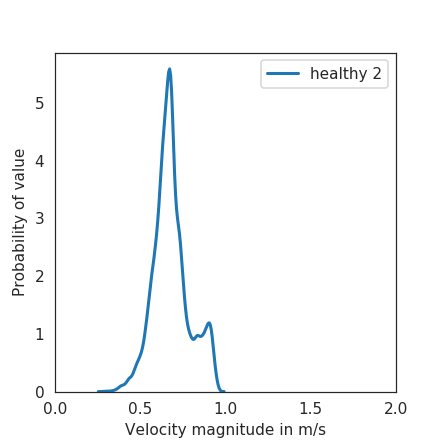

<IPython.core.display.Javascript object>


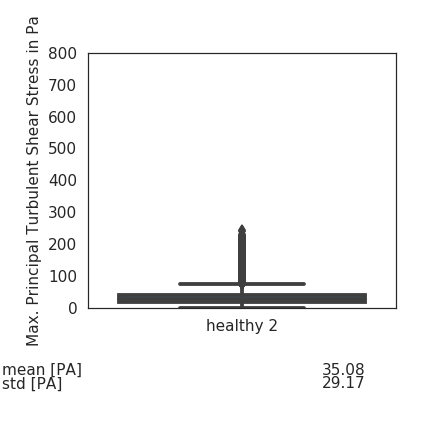

<IPython.core.display.Javascript object>


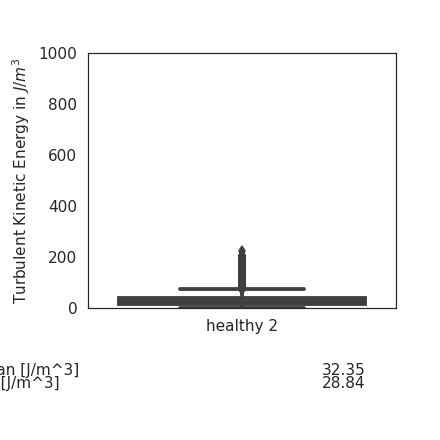

<IPython.core.display.Javascript object>


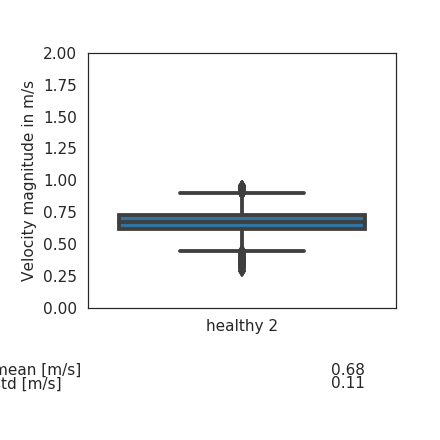

In [19]:
    
createHistPlot(df_TAU,'','Max. Principal Turbulent Shear Stress in Pa',vRange_tau,colInd,'Hist_PS.svg','[PA]')
createHistPlot(df_TKE,'','Turbulent Kinetic Energy in $J/m^3$',vRange_TKE,colInd,'Hist_TKE.svg','[J/m^3]')
createHistPlot(df_vmag,'','Velocity magnitude in m/s',vRange_vel,colInd,'Hist_vmag.svg','[m/s]')
    
createBoxPlot(df_TAU,'','Max. Principal Turbulent Shear Stress in Pa',vRange_tau,colInd,'box_PS.svg','[PA]')
createBoxPlot(df_TKE,'','Turbulent Kinetic Energy in $J/m^3$',vRange_TKE,colInd,'box_TKE.svg','[J/m^3]')
createBoxPlot(df_vmag,'','Velocity magnitude in m/s',vRange_vel,colInd,'box_vmag.svg','[m/s]')

